In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

### 1. Маятник – материальная точка с m = 1 кг, L= a м, момент силы трения в оси пропорционален углу отклонения с коэффициентом 0.02;

In [3]:
m = 1
L = 1
g = 9.81
k = 0.02

### 2. Вычислите дифференциальное уравнение регулируемой системы, её передаточную функцию. Всюду можно предполагать, что отклонения угла поворота маятника от нуля достаточно малы.

In [4]:
# (mL^2p^2 - 0.98mgL)θ = M => θ = M / (mL^2p^2 - 0.98mgL)

dT = 0.1
TotalTime = 50
Tin = np.linspace(0, TotalTime, TotalTime/dT + 1)
sys_tf = signal.TransferFunction([1], [m*L**2, 0, -0.98*m*g*L])

sys_tf

TransferFunctionContinuous(
array([1.]),
array([ 1.    ,  0.    , -9.6138]),
dt: None
)

### 3. Представьте систему с помощью уравнения состояния. Проинтерпретируйте переменные состояния.

In [5]:
sys_tf = signal.tf2ss([1], [m*L**2, 0, -0.98*m*g*L])
sys_tf

# z1* = 9.6138z2 + M
# z2* = z1
# θ = z2
# z2 - угол отклонения
# z1 - скорость угла отклонения

(array([[-0.    ,  9.6138],
        [ 1.    ,  0.    ]]), array([[1.],
        [0.]]), array([[0., 1.]]), array([[0.]]))

### 4. Промоделируйте свободное (т.е. без включения двигателя) движение маятника из малого ненулевого угла. Упадёт ли при этом маятник?

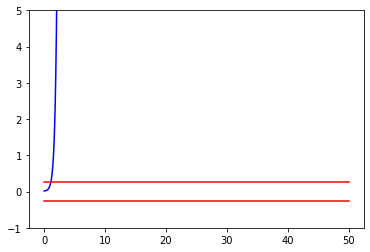

In [6]:
zero_input = np.zeros(Tin.shape) # не будем прилагать момент => M = 0
start_pos = 1 / 180.0 * np.pi # начнём с позиции в 1°.
Tout, yout, xout = signal.lsim(sys_tf, zero_input, Tin, X0=[0, start_pos]) # начальная скорость нулевая, угол - start_pos

ax = plt.axes()
ax.set_ylim([-1, 5])
# ax.set_xlim([0, 5])

plt.plot(Tout, yout, 'b')

# покажем предельные допустимые отклонения красными линиями
limit = 15 / 180.0 * np.pi

plt.plot([0, TotalTime], [limit, limit], 'r')
plt.plot([0, TotalTime], [-limit, -limit], 'r')

plt.show()
# Упадет

### 5. Добавьте в систему PID-регулятор. Проинтерпретируйте изменения в уравнении состояния.

In [7]:
P = 10
I = 0
D = 0

PID_num = [D, P, I]
PID_den = [1, 0]

T_num = [1]
T_den = [m*L**2, 0, -0.98*m*g*L]

interm_num = np.convolve(T_num, PID_num)
interm_den = np.convolve(T_den, PID_den)

total_sys = signal.tf2ss(interm_num, np.polyadd(interm_den, interm_num))

total_sys

# z1* ~ z2 + M
# z2* ~ z1 => z1 - угловая скорость
# z3* ~ z2 => z3 - интегральное отклонение
# θ ~ z2 => z2 - текущее отклонение

/usr/local/lib/python3.7/site-packages/scipy/signal/filter_design.py:1619: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


(array([[-0.    , -0.3862, -0.    ],
        [ 1.    ,  0.    ,  0.    ],
        [ 0.    ,  1.    ,  0.    ]]), array([[1.],
        [0.],
        [0.]]), array([[ 0., 10.,  0.]]), array([[0.]]))

In [8]:
A, B, C, D = total_sys

### 6. Настройте PID-регулятор так, чтобы он возвращал маятник в положение равновесия за время меньше 10 с из всех допустимых отклонений (±15°).

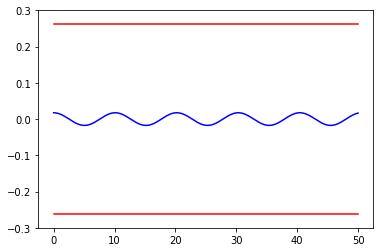

In [9]:
zero_input = np.zeros(Tin.shape) # не будем прилагать момент
start_pos = 1 / 180.0 * np.pi # начнём с позиции в 1°.
Tout, yout, xout = signal.lsim(total_sys, zero_input, Tin, X0=[0, start_pos/C[0][1], 0]) # начальная скорость нулевая, угол - start_pos

ax = plt.axes()
ax.set_ylim([-.3, .3])

plt.plot(Tout, yout, 'b')

# покажем предельные допустимые отклонения красными линиями
limit = 15 / 180.0 * np.pi

plt.plot([0, TotalTime], [limit, limit], 'r')
plt.plot([0, TotalTime], [-limit, -limit], 'r')

plt.show()

In [10]:
P_kr = P
T_kr = 100

P = 10  # 0.6 * P_kr
I = 5  # 1.2 * P_kr / T_kr
D = 12  # 3 * P_kr * T_kr / 40

print(P, I, D)

10 5 12


In [11]:
PID_num = [D, P, I]
PID_den = [1, 0]

interm_num = np.convolve(T_num, PID_num)
interm_den = np.convolve(T_den, PID_den)

total_sys = signal.tf2ss(interm_num, np.polyadd(interm_den, interm_num))
print(total_sys)

# z1* ~ z2 + M
# z2* ~ z1 => z1 - угловая скорость
# z3* ~ z2 => z3 - интегральное отклонение
# θ ~ z1 + z2 + z3 => z2 - текущее отклонение

(array([[-12.    ,  -0.3862,  -5.    ],
       [  1.    ,   0.    ,   0.    ],
       [  0.    ,   1.    ,   0.    ]]), array([[1.],
       [0.],
       [0.]]), array([[12., 10.,  5.]]), array([[0.]]))


In [12]:
A, B, C, D = total_sys

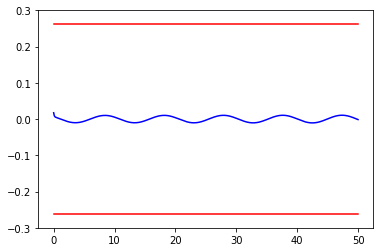

In [14]:
zero_input = np.zeros(Tin.shape) # не будем прилагать момент => M = 0
start_pos = 1 / 180.0 * np.pi # начнём с позиции в 1°
Tout, yout, xout = signal.lsim(total_sys, zero_input, 
                               Tin, X0=[start_pos/3/C[0][0], start_pos/3/C[0][1], start_pos/3/C[0][2]])

ax = plt.axes()
ax.set_ylim([-.3, .3])

plt.plot(Tout, yout, 'b')

# покажем предельные допустимые отклонения красными линиями
limit = 15 / 180.0 * np.pi

plt.plot([0, TotalTime], [limit, limit], 'r')
plt.plot([0, TotalTime], [-limit, -limit], 'r')

plt.show()